# Using Logistic Regression

Install PySpark and Spark NLP Libraries

In [ ]:
# Install the pyspark package to write Spark applications using Python
# This line installs the Spark NLP package, an NLP library built on top of Apache Spark.
# Downloads the script file colab.sh from the specified URL and immediately executes it using bash
# Script is designed to set up a Colab environment with specific versions of PySpark and Spark NLP
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2023-12-15 06:24:34--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2023-12-15 06:24:35--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1191 (1.2K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.16K  --.-KB/s    in 0s      

2023-12-15 06:24:35 (86.8 MB/s) - written to stdout [1191/1191]

Installing

In [ ]:
# Install the langdetect library
# Purpose: langdetect is used for language detection in text.
# It identifies the language of a given text or document.
!pip install langdetect

# Install the nltk library
# Purpose: nltk (Natural Language Toolkit) is a powerful library for natural language processing (NLP) and text analysis.
# It provides various tools for tasks like tokenization, stemming, POS tagging, etc.
!pip install nltk

# Install the pyspellchecker library
# Purpose: pyspellchecker is used for spell checking in Python.
# It helps identify and correct misspelled words in text documents.
!pip install pyspellchecker

Import Required Libaries and Methods

In [ ]:
# Imports the main PySpark library, providing access to functionalities for distributed computing.
import pyspark
# Creates and manages SparkSession, which is the entry point to programming Spark with the DataFrame API.
from pyspark.sql import SparkSession
# Imports Window functions for defining window specifications in DataFrame operations
from pyspark.sql.window import Window
# Imports the functions module from PySpark SQL, allowing access to various built-in functions for DataFrame operations
from pyspark.sql import functions as F
# Imports specific functions commonly used in DataFrame operations
from pyspark.sql.functions import col, regexp_replace, count, isnan, when
# Imports the Pipeline class for assembling multiple stages into a single workflow.
from pyspark.ml import Pipeline
# Used to evaluate multiclass classification models based on different metrics like accuracy, precision, recall, etc.
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Importing TF-IDF methods for feature extraction in PySpark ML
from pyspark.ml.feature import HashingTF, IDF
# Importing classification algorithms (Linear Regression, Random Forest, Naive Bayes) from PySpark ML
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes
# Importing evaluator for regression evaluation in PySpark ML
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Import class with methods to compute metrics specifically tailored for multiclass classification problems
from pyspark.mllib.evaluation import MulticlassMetrics

# Imports the Spark NLP library, enabling access to functionalities for NLP
import sparknlp
# Import various classes, methods, and utilities from Spark NLP for base functionalities,
# common components, and annotators
from sparknlp.base import *
from sparknlp.common import *
from sparknlp.annotator import *

# Importing NLTK for natural language processing tasks
import nltk
# Importing NLTK's SnowballStemmer for word stemming
from nltk.stem import SnowballStemmer
# Importing word_tokenize method for tokenizing text into words
from nltk.tokenize import word_tokenize
# Downloading NLTK resources - stopwords and punkt tokenizer models
nltk.download('stopwords')
nltk.download('punkt')

# Importing SpellChecker for spell checking in text
from spellchecker import SpellChecker

# Importing language detection method from langdetect library
from langdetect import detect

# Importing regex module for pattern matching and manipulation
import re

# Importing string module for string manipulation
import string

# Importing various data types for PySpark DataFrame columns
from pyspark.sql.types import ArrayType, IntegerType, StringType, DoubleType

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Initiate SparkContext and SparkSession and Import Google Drive Module

In [ ]:
# Initiates a SparkContext and a SparkSession using the Spark NLP library
spark = sparknlp.start()

# Check version of the Spark NLP library and Apache Spark being used in the
# current Spark session
print("Spark NLP version: {}".format(sparknlp.version()))
print("Apache Spark version: {}".format(spark.version))

Spark NLP version: 5.2.0
Apache Spark version: 3.2.3


In [ ]:
# This line imports the drive module from the google.colab library
from google.colab import drive
# Mounts your Google Drive into the Colab environment at the specified directory path /content/drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Function Definition: Converting CSV to DataFrame

In [ ]:
# Method to convert CSV to pandas DataFrame
def csv_to_df(file_path):
    """
      Converts a CSV file to a pandas DataFrame

      Parameters:
         filePath: The path to the CSV file, to be converted into a pandas DataFrame

      Returns:
         df: The newly created pandas DataFrame
    """

    # File location and type
    file_type = "csv" # Specify that the file type is a CSV. Other file types will be ignored.

    # CSV options
    infer_schema = "true" # Infer schema automatically while reading the CSV
    first_row_is_header = "true" # Treat the first row as header
    delimiter = "," # Define the delimiter used in the CSV file

   # Read the CSV file into a DataFrame using Spark
   # Allowing multiline entries in the CSV
   # Specifying an escape character for CSV entries
    df = spark.read.format(file_type) \
         .option("inferSchema", infer_schema) \
         .option("header", first_row_is_header) \
         .option("sep", delimiter) \
         .option("multiline","True") \
         .option("escape","\"") \
         .load(file_path)

    # Return DataFrame
    return df

Function Definition: Evaluate Performance of Multiclassification Models

In [ ]:
def eval(predictions):
    """
        Evaluates the performance of a multiclassification model by calculating
        the accuracy and F1 score and printing them

        Parameters:
            predictions: DataFrame with predicted labels using a trained model
            and added as a column under the name "prediction"

        Returns:
            None
    """

    # Initialize a MulticlassClassificationEvaluator specifying evaluation parameters
    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label_numeric",
                                                      predictionCol="prediction_numeric",
                                                      metricName="accuracy")
    accuracy = accuracy_evaluator.evaluate(predictions)
    print("Accuracy: %g" % (accuracy))

    # Calculate the F1 score
    f1_evaluator = MulticlassClassificationEvaluator(labelCol="label_numeric",
                                                     predictionCol="prediction_numeric",
                                                     metricName="f1")
    f1_score = f1_evaluator.evaluate(predictions)
    print("F1 Score:", f1_score)

Function Definition: Confusion Matrix, Precision, Recall

In [ ]:
# Compute confusion matrix

def confusion_matrix(predictions):
    """
        Uses a DataFrame with predictions and prints a confusion matrix and a
        precision and recall metrics for each class

        Parameters:
          predictions: DataFrame with predicted labels using a trained model
          and added as a column under the name "prediction"

        Returns:
          None
    """
    predictions = predictions.withColumn("label_numeric", predictions["label_numeric"].cast(DoubleType()))
    predictions = predictions.withColumn("prediction_numeric",
                                         predictions["prediction_numeric"].cast(DoubleType()))

    predictions_and_labels = predictions.select("prediction_numeric", "label_numeric").rdd
    metrics = MulticlassMetrics(predictions_and_labels)
    confusion_matrix = metrics.confusionMatrix().toArray()

    print("Confusion Matrix:")
    print(confusion_matrix)

    print("Precision for negative: %.3f" % metrics.precision(0.0))
    print("Recall for negative: %.3f" % metrics.recall(0.0))

    print("Precision for neutral: %.3f" % metrics.precision(1.0))
    print("Recall for neutral: %.3f" % metrics.recall(1.0))

    print("Precision for positive: %.3f" % metrics.precision(2.0))
    print("Recall for positive: %.3f" % metrics.recall(2.0))

Function Definition: Preprocess Text

In [ ]:
from pyspark.sql.functions import udf

# Define a user-defined function (UDF) for text preprocessing, which takes a review as input
@udf(returnType=ArrayType(StringType()))
def preprocess_text(review):
    """
      Preprocesses the text for each review by tokenizing it, filtering out stopwords, removing non-alphabetic words and
      punctuation marks, correct misspelled words, and stemming each word to create a new array of words

      Parameters:
         review: The string that represents comments the customer had on their AirBnb experience

      Return:
         words: An array of strings consisting of the keywords in each review.

    """
    # Importing NLTK's stopwords corpus for filtering common words
    from nltk.corpus import stopwords

    # Tokenize the review into words
    words = word_tokenize(review)

    # Create a set of English stopwords to filter out common words
    stop_words = set(stopwords.words("english"))

    # Remove stopwords from the list of words
    words = [word for word in words if word not in stop_words]

    # Define a set of punctuation marks
    punctuation = set(string.punctuation)

    # Remove punctuation marks from the words list
    words = [word for word in words if word not in punctuation]

    # Remove non-alphabetic words from the list
    words = [word for word in words if word.isalpha()]

    # Initialize SpellChecker for identifying misspelled words
    spell = SpellChecker()

    # Identify misspelled words in the list
    misspelled = spell.unknown(words)

    # Correct misspelled words and build a new list of words
    new_words = []
    for word in words:
        if word in misspelled:
            corrected = spell.correction(word)
            if corrected:
                new_words.append(corrected)
        else:
            new_words.append(word)

    # Use Snowball Stemmer to stem each word in the list
    snowball = SnowballStemmer(language='english')
    stemmed_words = [snowball.stem(word) for word in new_words]

    # Return the preprocessed words
    return words

Load CSV of Reviews from Google Drive

In [ ]:
labeled_data_fileName = "500-combined-reviews.csv"
file_path = "/content/drive/My Drive/ENSF 612/michael-2nd-attempt/" + labeled_data_fileName
labeled_reviews = csv_to_df(file_path)
labeled_reviews.show()

+----------+------------+-----+-----------+-------------+--------------------+--------+
|listing_id|          id| date|reviewer_id|reviewer_name|            comments|   label|
+----------+------------+-----+-----------+-------------+--------------------+--------+
|  30760930|     4.65E17|44472|  393558848|       Vedran|Great place to st...|Positive|
|  19670926|     5.45E17|44583|  298988889|      Jessica|Very friendly sta...|Positive|
|   1436172| 4.0195688E7|42214|   26275433|        Steve|Paul greeted us i...|Positive|
|   1436177| 6.1524319E7|42405|   33548804|        Fiona|Paul made us very...|Positive|
|   2126708| 1.1719182E7|41742|   13309664|    Katherine|Staying at this v...|Positive|
|   3855375| 5.5345498E8|43762|  299045505|        Joely|Great price and g...|Positive|
|   2659707| 5.5056253E7|42335|   49116216|     Weihsuan|It was a great fi...|Positive|
|   4748665|     8.28E17|44973|  284499594|         Kurt|Appartment was sp...|Positive|
|   5266466|4.68360423E8|43628| 

Exploratory Data Analysis

In [ ]:
# Get the number of rows
num_rows = labeled_reviews.count()

# Get the number of columns
num_columns = len(labeled_reviews.columns)

# Display the shape (number of rows and columns)
print("Number of rows: ", num_rows)
print("Number of columns: ", num_columns)

Number of rows:  500
Number of columns:  7


In [ ]:
# Count the original number of rows
original_count = labeled_reviews.count()

# Remove duplicates and count the remaining rows
distinct_count = labeled_reviews.dropDuplicates().count()

# Calculate the count of duplicate rows
duplicate_count = original_count - distinct_count

# Display the count of duplicate rows
print("Number of duplicate rows: ", duplicate_count)

Number of duplicate rows:  0


In [ ]:
# Show the counts for each sentiment class in the labeled data
label_counts = labeled_reviews.groupBy("label").count()
label_counts.show()

+--------+-----+
|   label|count|
+--------+-----+
|Positive|  331|
| Neutral|   90|
|Negative|   79|
+--------+-----+



In [ ]:
!pip install matplotlib pandas
import matplotlib.pyplot as plt

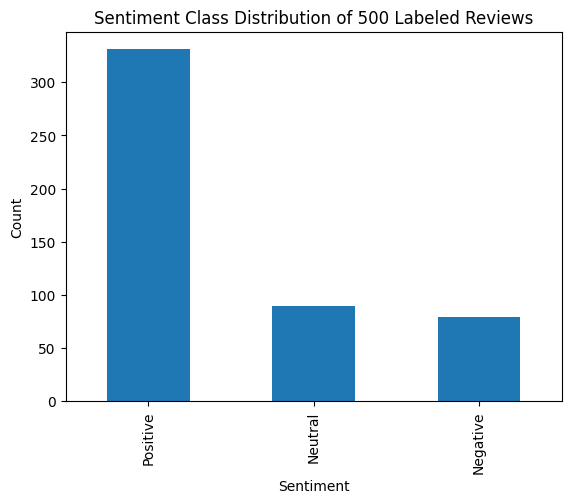

In [ ]:
# Create DataFrame of label counts
label_counts_df = label_counts.toPandas()

# Plot the label counts in a bar graph
label_counts_df.plot(kind='bar', x='label', y='count', legend=False)
plt.title('Sentiment Class Distribution of 500 Labeled Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

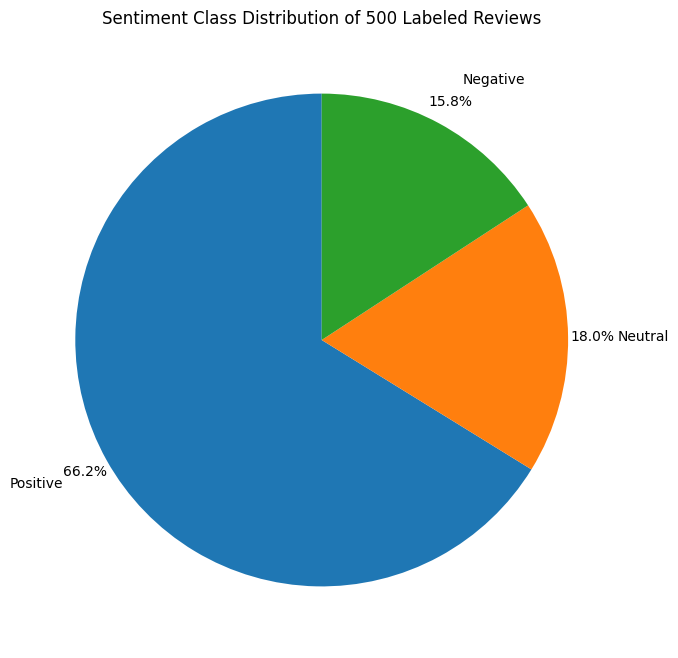

In [ ]:
# Plot the label counts in a pie graph
plt.figure(figsize=(8, 8))
plt.pie(label_counts_df['count'], labels=label_counts_df['label'], autopct='%1.1f%%', pctdistance=1.1, labeldistance=1.2, startangle=90)
plt.title('Sentiment Class Distribution of 500 Labeled Reviews')
plt.show()

Rename the comments column to "text", so that it can be used in the PretrainedPipeline model

In [ ]:
# Rename comments column to text
labeled_reviews = labeled_reviews.withColumnRenamed("comments", "text")

Preprocess Text Reviews Using preprocess_text Function

In [ ]:
try:
  processed_reviews = labeled_reviews.withColumn('processed_text', preprocess_text(labeled_reviews['text']))
except RuntimeError:
  processed_reviews = labeled_reviews.withColumn('processed_text', preprocess_text(col('text')))

processed_reviews.show()

+----------+------------+-----+-----------+-------------+--------------------+--------+--------------------+
|listing_id|          id| date|reviewer_id|reviewer_name|                text|   label|      processed_text|
+----------+------------+-----+-----------+-------------+--------------------+--------+--------------------+
|  30760930|     4.65E17|44472|  393558848|       Vedran|Great place to st...|Positive|[Great, place, st...|
|  19670926|     5.45E17|44583|  298988889|      Jessica|Very friendly sta...|Positive|[Very, friendly, ...|
|   1436172| 4.0195688E7|42214|   26275433|        Steve|Paul greeted us i...|Positive|[Paul, greeted, u...|
|   1436177| 6.1524319E7|42405|   33548804|        Fiona|Paul made us very...|Positive|[Paul, made, us, ...|
|   2126708| 1.1719182E7|41742|   13309664|    Katherine|Staying at this v...|Positive|[Staying, venue, ...|
|   3855375| 5.5345498E8|43762|  299045505|        Joely|Great price and g...|Positive|[Great, price, gr...|
|   2659707| 5.5056

In [ ]:
processed_reviews_count = processed_reviews.groupby("label").count()
processed_reviews_count.show()

+--------+-----+
|   label|count|
+--------+-----+
|Positive|  331|
| Neutral|   90|
|Negative|   79|
+--------+-----+



Convert Text Labels to Numeric Representations

In [ ]:
processed_reviews = processed_reviews.withColumn(
    "label_numeric",
    when(col("label") == "Positive", 2.0)
    .when(col("label") == "Negative", 0.0)
    .otherwise(1.0)
)

Use HashingTF to Convert the processed_text Array to a Features Array and Create Training and Testing Sets

In [ ]:
# Initialize a HashingTF object that will take 'processed_text' as input and add a 'features' column as the output
# Features is a numerical vector representation of the words in the processed_text array
hashTF = HashingTF(inputCol="processed_text", outputCol="features")

# Transform the DataFrame 'df_processed' using the HashingTF object
df_processed_with_hash = hashTF.transform(processed_reviews)

# Randomly split the df_processed_with_hash into training (70%) and testing sets (30%)
(train_dataset, test_dataset) = df_processed_with_hash.randomSplit([0.7, 0.3])

# Display training set and confirm that the features column has been added
train_dataset.show()

+----------+------------+-----+-----------+-------------+--------------------+--------+--------------------+-------------+--------------------+
|listing_id|          id| date|reviewer_id|reviewer_name|                text|   label|      processed_text|label_numeric|            features|
+----------+------------+-----+-----------+-------------+--------------------+--------+--------------------+-------------+--------------------+
|     36660|  1.460015E7|41813|   11778553|    Alexandra|Agri and Roger ar...|Positive|[Agri, Roger, nic...|          2.0|(262144,[14390,17...|
|     42010|   6864585.0|41514|    3012342|       Amanda|Blenheim Lodge wa...|Positive|[Blenheim, Lodge,...|          2.0|(262144,[11018,42...|
|     85191|    376736.0|40740|     461754|    Ana María|Elisabetta was a ...|Positive|[Elisabetta, love...|          2.0|(262144,[172,3754...|
|     90700| 1.9039463E7|41887|    1700335|         Rose|Chil welcomed me ...| Neutral|[Chil, welcomed, ...|          1.0|(262144,[13020

Predicting Sentiments using Logistic Regression

In [ ]:
# Used to create a logistic regression model
from pyspark.ml.classification import LogisticRegression
# Represents a labeled point (a data point with a label/target) used in RDD-based API for regression and classification.
from pyspark.mllib.regression import LabeledPoint
# Implementation of logistic regression using the Limited-memory Broyden–Fletcher–Goldfarb–Shanno (LBFGS) optimization method
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
# Imports Vector (basic data type representing a vector) and Vectors (provides methods to create Vector instances)
from pyspark.ml.linalg import Vector as MLVector, Vectors as MLVectors
from pyspark.mllib.linalg import Vector as MLLibVector, Vectors as MLLibVectors

In [ ]:
# Converts the train_dataset DataFrame to an RDD
# Ceates a LabeledPoint for each row
# Takes the 'label' column value from the row as the label
# Converts the 'features' column into an array using toArray().
training_rdd = train_dataset.rdd.map(lambda row: LabeledPoint(row['label_numeric'], row['features'].toArray()))

# Train the logistic regression model
lr_model = LogisticRegressionWithLBFGS.train(training_rdd, numClasses=3)

# Converts the test_dataset DataFrame to an RDD
# Omit labels for evaluation purposes later
testing_rdd = test_dataset.rdd.map(lambda row: LabeledPoint(row['features'].toArray()))

In [ ]:
@udf(returnType=IntegerType())
def lr_multi_predict(vec):
    return lr_model.predict(MLLibVectors.fromML(vec))

In [ ]:
predictions_lr = test_dataset.withColumn("prediction", lr_multi_predict("features"))
predictions_lr = predictions_lr.withColumn("prediction", predictions_lr["prediction"].cast(DoubleType()))
predictions_lr.show()

+----------+------------+-----+-----------+-------------+--------------------+--------+--------------------+-------------+--------------------+----------+
|listing_id|          id| date|reviewer_id|reviewer_name|                text|   label|      processed_text|label_numeric|            features|prediction|
+----------+------------+-----+-----------+-------------+--------------------+--------+--------------------+-------------+--------------------+----------+
|     47192|1.62070171E8|42905|  130430472|     Lawrence|Dino is a respons...|Positive|[Dino, responsibl...|          2.0|(262144,[12910,17...|       2.0|
|     90700|   7064915.0|41522|    4021859|       Morgan|There is no way t...|Positive|[There, way, real...|          2.0|(262144,[13020,31...|       2.0|
|    102565|2.62618295E8|43229|   78933430|         Mary|Anne’s bunker fla...|Positive|[Anne, bunker, fl...|          2.0|(262144,[11436,14...|       2.0|
|    107051| 9.9435433E7|42617|   76576009|        Laura|We were made 

Convert Prediction Labels to Numeric Representations

In [ ]:
predictions_lr = predictions_lr.withColumn(
    "prediction_numeric",
    when(col("prediction") == "Positive", 2.0)
    .when(col("prediction") == "Negative", 0.0)
    .otherwise(1.0)
)

Evaluate Performance of Logistic Regression Model

In [ ]:
eval(predictions_lr)

Accuracy: 0.219697
F1 Score: 0.07914549218897045


Compared to the Random Forest models (21.19% and 17.78%) and Naive Bayes (19.87%) model, the performance of the Logistic Regression classification model of 21.97% is the best accuracy so far. The F1 score of 0.079 is also the best value compared to the Random Forest models and Naive Bayes model. However, these metrics for this model is only slightly better than those of the other models, and do not demonstrate any significant improvement.

In [ ]:
confusion_matrix(predictions_lr)

Confusion Matrix:
[[ 0. 21.  0.]
 [ 0. 29.  0.]
 [ 0. 82.  0.]]
Precision for negative: 0.000
Recall for negative: 0.000
Precision for neutral: 0.220
Recall for neutral: 1.000
Precision for positive: 0.000
Recall for positive: 0.000


The confusion matrix also speaks to the poor performance of the model, as the precision and recall scores of 0 for the negative and positive classes indicate that the model didn't make any correct predictions for both the negative and positive classes. The neutral class having a low precision score of 0.220 is indicative of a having more false positives compared to true positives. The high recall score of 1 for the neutral class indicates that when the actual class is neutral, the model correctly identifies most of them.

Although the results for Logistic Regression show slight improvement compared to the previous three models, the results are still quite poor and fall in line with their performance.

Overall, we have decided to use the model from the Pretrained Spark NLP pipeline from the notebook file "1-Pretrained Pipeline (IMDB Reviews).ipynb" for predicting the sentiments that will be used as a feature to predict our price because it's accuracy of 77% on the train set and 78% on the test set appears to have the best results with the least amount of issues. We chose not to use the custom pipeline with the SentimentDLApproach model because although the accuracy and F1 scores are good, it does not predict any negative reviews.

The code for the price prediction model will be explained in the notebook file "4-Price Prediction Model.ipynb"
